# Злонамеренные атаки (adversarial attacks) и катастрофическое забывание


В этом ноутбуке мы разберем на примерах, проблемы **адверсальных атак** и **катастрофического забывания**. 

Для этого мы:
- Обучим нейронную сеть для классификации изображений на датасете **FashionMNIST**
- Применим **FGSM-атаку**
- Сравним качество работы сети на атакованных и на оригинальных данных
- Рассмотрим пример **катастрофического забывания**:
-- переобучим нашу модель на датасете **MNIST**
-- сравним качество модели на новом дасатете **MNIST** и датасете **FashionMNIST**, на котором модель училась до этого



Напомним, что такое адверсальные атаки.

Цель **адверсальных атак** — изменить данные, на которых работает модель машинного обучения, так, чтобы она совершала некорректные предсказания для атакованного объекта. Иными словами, мы хотим немного <u>изменить исходные данные</u> так, чтобы модель стала работать <u>значительно хуже</u>, чем на <u>неатакованных данных</u>.


![Alt text](https://www.altacognita.com/content/images/2019/10/adv-examples.png "Пример адверсальной атаки")
*источник*: https://www.altacognita.com/robust-attribution/ 

## Инициализация среды

Для работы в данном ноутбуке мы будем пользоваться библиотеками [PyTorch](https://pytorch.org/) и [TorchVision](https://pytorch.org/vision/stable/index.html) в качестве инструмента работы с нейронными сетями.

Импортируем эти и другие необходимые модули.

In [ ]:
#import os
import random
from tqdm.notebook import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Зафиксируем random seed, чтобы сделать наши эксперименты вопроизводимыми.

In [ ]:
manualSeed = 42
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  42


Для более быстрого обучения нейронных сетей в `PyTorch` можно использовать видеокарту, поддерживающую технологию CUDA. Если на вашем устройстве есть **видеокарта**, то ячейка ниже поможет **автоматически переключить** вычисления на нее. Если у вас **нет видеокарты**, не переживайте, вы можете работать с данным ноутбуком, но вычисления будут происходить **медленнее**.

Если вы работаете в Google Colab, не забудьте выбрать **среду выполнения GPU**.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Подготовка данных

В качестве датасета мы выбрали датасет [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Датасет представляет собой черно-белые картинки размером 28 x 28 пикселей с изображением элементов одежды. Всего в датасете 10 классов.

Вам **не придется** отдельно скачивать данные, так как в модуле `torchvision` уже представлен интерфейс работы с данным датасетом.

Создадим классы Dataset и Dataloader для тренировочной и тестовой частей нашего датасета.

**Внимание!** Если на вашу видеокарту не помещается модель, сделайте параметр `batch_size` меньше.

In [ ]:
batch_size = 64

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5), (0.5))])

train_set = torchvision.datasets.FashionMNIST(root='FashionMNIST', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

test_set = torchvision.datasets.FashionMNIST(root='FashionMNIST', train=False,
                                        download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



Взглянем на наши изображения:

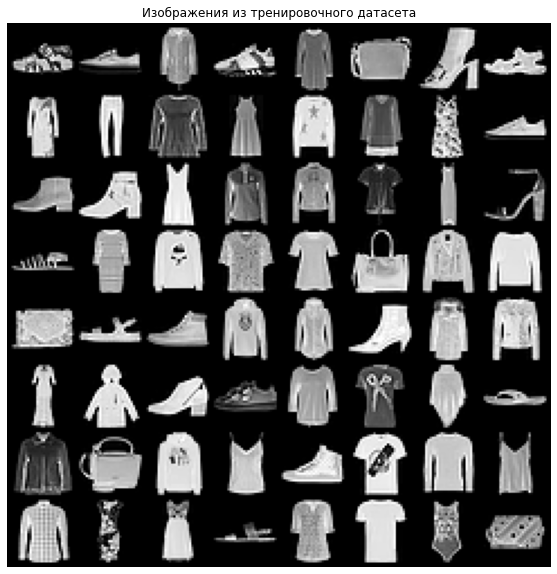

In [ ]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

real_batch = next(iter(train_loader))

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Изображения из тренировочного датасета")
plt.show()

In [ ]:
real_batch[0].shape

torch.Size([64, 1, 28, 28])

Размерность наших изображений — 28 х 28. Картинки имеют 1 канал.

## обучение модели

В качестве модели мы выбрали [ResNet18](https://pytorch.org/hub/pytorch_vision_resnet/). Для экономии времени мы не будем самостоятельно инициализировать модель, а возьмем предобученную версию из модуля `torchvision`.

Поскольку наши картинки черно-белые (имеют на входе 1 канал вместо 3, как у цветных картинок), и в нашем датасете 10 классов, а не 1 000, нам необходимо поменять количество входных каналов и размерность выходного вектора. 

In [ ]:
n_input_channel = 1
n_classes = 10

clf = torchvision.models.resnet18(pretrained=True) 

# изменение входных размерностей
layer = clf.conv1
clf.conv1 = nn.Conv2d(in_channels=n_input_channel, # меняем здесь
                  out_channels=layer.out_channels, 
                  kernel_size=layer.kernel_size, 
                  stride=layer.stride, 
                  padding=layer.padding)

# меняем количество классов на выходе
layer = clf.fc
clf.fc = nn.Linear(in_features=layer.in_features, 
                      out_features=n_classes) # меняем здесь

clf = clf.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

В качестве функции потерь будем использовать кросс-энтропию, в качестве оптимизатора — Adam.

In [ ]:
lr = 0.0001
beta1 = 0.5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=lr, betas=(beta1, 0.999))

Обучим нашу нейронную сеть:

In [ ]:
def epoch_train(loader, clf, criterion, opt):

    all_preds_number = 0
    correct_preds = 0
    losses = 0
    n_batches = 0

    clf.train(True)
    
    for images, labels in loader:

        opt.zero_grad()
        labels = labels.to(device)
        images = images.to(device)
        
        if not images.requires_grad:
            images.grad = None
            images.requires_grad = True


        y_out = clf(images)
        loss = criterion(y_out, labels)
        losses += loss
        
        y_out_labels = torch.log_softmax(y_out, dim = 1)
        y_out_labels = torch.argmax(y_out_labels, dim = 1)
        
        all_preds_number += labels.size(0)
        correct_preds += (y_out_labels == labels).sum().item()
        
        n_batches += 1
        loss.backward()
        opt.step()
        
    mean_loss = losses / n_batches
    mean_acc = correct_preds / all_preds_number
    return mean_loss, mean_acc

def epoch_test(loader, clf, criterion):

    all_preds_number = 0
    correct_preds = 0
    losses = 0
    n_batches = 0
    
    clf.eval()
    
    with torch.no_grad():
        for images, labels in loader:

            labels = labels.to(device)
            images = images.to(device)

            y_out = clf(images)
            loss = criterion(y_out, labels)
            losses += loss

            y_out_labels = torch.log_softmax(y_out, dim = 1)
            y_out_labels = torch.argmax(y_out_labels, dim = 1)

            all_preds_number += labels.size(0)
            correct_preds += (y_out_labels == labels).sum().item()

            n_batches += 1
        
    mean_loss = losses / n_batches
    mean_acc = correct_preds / all_preds_number
    return mean_loss, mean_acc        


def train(train_loader, test_loader, clf, criterion, opt, n_epochs=10):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

In [ ]:
train(train_loader, test_loader, clf, criterion, optimizer, n_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.544; train acc: 0.80; test loss: 0.396; test acc: 0.86
[Epoch 2] train loss: 0.349; train acc: 0.87; test loss: 0.352; test acc: 0.87
[Epoch 3] train loss: 0.293; train acc: 0.89; test loss: 0.325; test acc: 0.88
[Epoch 4] train loss: 0.257; train acc: 0.90; test loss: 0.308; test acc: 0.89
[Epoch 5] train loss: 0.225; train acc: 0.92; test loss: 0.309; test acc: 0.89
[Epoch 6] train loss: 0.201; train acc: 0.92; test loss: 0.301; test acc: 0.90
[Epoch 7] train loss: 0.181; train acc: 0.93; test loss: 0.311; test acc: 0.89
[Epoch 8] train loss: 0.157; train acc: 0.94; test loss: 0.325; test acc: 0.89
[Epoch 9] train loss: 0.143; train acc: 0.95; test loss: 0.315; test acc: 0.90
[Epoch 10] train loss: 0.120; train acc: 0.95; test loss: 0.346; test acc: 0.90


## Злонамеренные атаки

Когда наша модель готова, мы можем приступить к атакам. В качестве способа атаки мы будем использовать метод атаки FGSM: 

$$ x_{attacked} = x + \epsilon \cdot sign(\nabla_x J (\theta, x, y)), $$

где $ \nabla_x J (\theta, x, y) $ — градиент от функции потерь модели.

In [ ]:
def req_grad(model, state):
    for param in model.parameters():
        param.requires_grad_(state)

In [ ]:
def attack_model(loader, clf, criterion, eps=0.001, get_adv_images=False):
   
    # переменные для логирования результата
    correct_preds, correct_preds_adv = 0, 0
    losses, losses_adv = 0, 0
    all_preds_number, n_batches = 0, 0
    
    # Включаем градиент для нашей модели
    req_grad(clf, state=True)
    clf.train()
    
    # логирование изображений
    if get_adv_images:
        images_adv_tensor = torch.FloatTensor([])
        labels_tensor = torch.LongTensor([])

    for images, labels in loader:

        labels = labels.to(device)
        images = images.to(device)
        images.grad = None
        images.requires_grad = True

        # получаем предсказание на неатакованных данных
        y_out = clf(images)
        loss = criterion(y_out, labels)        

        # атакуем данные при помощи FGSM метода
        images_adv = images + torch.sign(torch.autograd.grad(loss, images, retain_graph=True)[0]) * eps

        # логируем метрики
        losses += loss.detach().cpu()
        y_out_labels = torch.argmax(y_out, dim = 1)
        correct_preds += (y_out_labels == labels).sum().item()
        
        # получаем предсказание на атакованных данных
        with torch.no_grad():
            y_out_adv = clf(images_adv)
            loss_adv = criterion(y_out_adv, labels)
            losses_adv += loss_adv
        
        # логируем метрики
        y_out_labels_adv = torch.argmax(y_out_adv, dim = 1)
        correct_preds_adv += (y_out_labels_adv == labels).sum().item()
    
        if get_adv_images:
            img_adv =  torch.clip(images_adv.cpu().detach(), -1, 1)
            images_adv_tensor = torch.cat((images_adv_tensor,img_adv), dim=0)
            labels_tensor = torch.cat((labels_tensor, labels.cpu().detach()), dim=0)
             
        all_preds_number += labels.size(0)
        n_batches += 1
        
    mean_loss = losses / n_batches
    mean_acc = correct_preds / all_preds_number
    
    mean_loss_adv = losses_adv / n_batches
    mean_acc_adv = correct_preds_adv / all_preds_number
    
    if get_adv_images:
        return (mean_loss, mean_acc, mean_loss_adv, mean_acc_adv), (images_adv_tensor, labels_tensor)
    else:
        return (mean_loss, mean_acc, mean_loss_adv, mean_acc_adv), None 

Посмотрим, насколько изменилась точность предсказания после FGSM-атаки с $\epsilon$ равным 0,05:

In [ ]:
eps = 0.05

metrics, _ = attack_model(test_loader, clf, criterion, eps=eps, get_adv_images=False)

org_loss, org_acc, att_loss, att_acc = metrics 
print(f'Неатакованный loss: {org_loss:.3f}; Неатакованная acc: {org_acc:.2f}; ' + 
        f'Атакованный loss: {att_loss:.3f}; Атакованная acc: {att_acc:.2f}')

Неатакованный loss: 0.361; Неатакованная acc: 0.89; Атакованный loss: 2.165; Атакованная acc: 0.69


Оценим, как точность предсказания зависит от параметра $\epsilon$:

  0%|          | 0/11 [00:00<?, ?it/s]

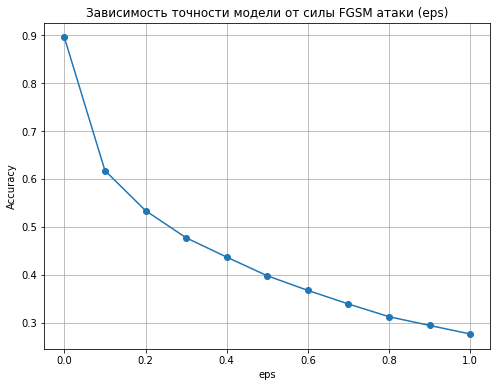

In [ ]:
eps_list = np.linspace(0.0, 1, 11)
acc_list = []

for eps in tqdm(eps_list):

    metrics, adv_data = attack_model(test_loader, clf, criterion, eps=eps, get_adv_images=True)
    images_adv, labels_adv = adv_data

    org_loss, org_acc, att_loss, att_acc = metrics 
    acc_list.append(att_acc)

plt.figure(figsize=(8, 6))

plt.title('Зависимость точности модели от силы FGSM атаки (eps)')
plt.plot(eps_list, acc_list, marker='o')
plt.xlabel('eps')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

Как мы видим, чем больше $\epsilon$, тем сильнее падает качество предсказания нашей модели

## Сравнение с реальными изображениями

Теперь давайте сравним, как выглядят обычные и атакованные изображения:

In [ ]:
def plot_images(images, labels, preds):
    
    len_batch = len(images)
    plt.figure(figsize=(20, 3))
    
    for i in range(len(images)):
        
        plt.subplot(1, len_batch, i+1)
        original_img = images[i] / 2 + 0.5     # unnormalize
        
        matrix_image = original_img.numpy()

        if matrix_image.shape[0] == 1:
            image = matrix_image[0]
            matrix_image = np.array([image, image, image])

        plt.imshow(np.transpose(matrix_image, (1, 2, 0)))

        plt.title(f'{classes[labels[i].numpy()]} | {classes[preds[i].numpy()]}')
        plt.axis('off')
        plt.xlabel(f'pred cl {classes[preds[i].numpy()]}')

def model_predict(clf, X):
    with torch.no_grad():
        X = X.to(device)
        preds = clf(X)
        preds = torch.argmax(preds, dim = 1)
    return preds.cpu().detach()

In [ ]:
eps = 0.2

metrics, adv_data = attack_model(test_loader, clf, criterion, eps=eps, get_adv_images=True)
images_adv, labels_adv = adv_data

org_loss, org_acc, att_loss, att_acc = metrics 
print(f'Неатакованный loss: {org_loss:.3f}; Неатакованная acc: {org_acc:.2f}; ' + 
        f'Атакованный loss: {att_loss:.3f}; Атакованная acc: {att_acc:.2f}')

Неатакованный loss: 0.361; Неатакованная acc: 0.89; Атакованный loss: 3.414; Атакованная acc: 0.53


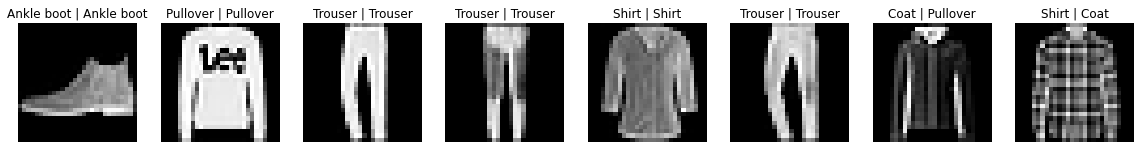

In [ ]:
n_images = 8

dataiter = iter(test_loader)
images, labels = dataiter.next()

images_sample = images[:n_images]
labels_sample = labels[:n_images]

preds_adv = model_predict(clf, images_sample)
plot_images(images_sample, labels_sample, preds_adv)

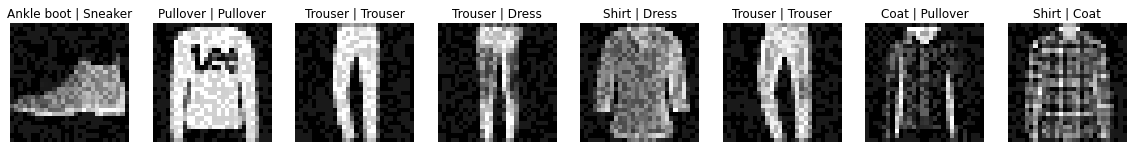

In [ ]:
n_images = 8

dataiter = iter(test_loader)
images, labels = dataiter.next()

images_sample = images_adv[:n_images]
labels_sample = labels[:n_images]

preds_adv = model_predict(clf, images_sample)
plot_images(images_sample, labels_sample, preds_adv)

Как мы видим, модель при добавлении возмущений начала ошибаться на некоторых объектах, которые для человеческого глаза все еще остаются различимыми.

# Катастрофическое забывание

Катастрофическим забыванием называют ситуацию, когда нейронная сеть, дообученная на новых данных, плохо справляется c предсказанием данных, на которых она училась первоначально. Давайте рассмотрим эту проблему на реальном примере. 

У нас есть модель ResNet, дообученная на датасете FashionMNIST. Давайте попробуем нашу сеть дообучить на новом, похожем датасете — MNIST и посмотрим, как она справится с предсказанием на тестовой выборке из обоих датасетов.

In [ ]:
test_loss, test_acc = epoch_test(test_loader, clf, criterion)

print(f'FashionMNIST test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

FashionMNIST test loss: 0.416; test acc: 0.87


Подгрузим датасет MNIST при помощи инструментов `torchvision` и создадим `dataloader` для train- и test-частей этого датасета. 

In [ ]:
batch_size = 64

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5), (0.5))])

train_set = torchvision.datasets.MNIST(root='MNIST', train=True,
                                        download=True, transform=transform)

train_loader_MNIST = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

test_set = torchvision.datasets.MNIST(root='MNIST', train=False,
                                        download=True, transform=transform)

test_loader_MNIST = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



Дообучим нашу модель только 1 эпоху на новом датасете. 

In [ ]:
req_grad(clf, state=True)
lr = 0.0001
beta1 = 0.5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=lr, betas=(beta1, 0.999))

train(train_loader_MNIST, test_loader_MNIST, clf, criterion, optimizer, n_epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.258; train acc: 0.93; test loss: 0.061; test acc: 0.98


Как мы видим, модель довольно хорошо справляется с тестовой выборкой на датасете MNIST даже при 1 эпохе дообучения. А что же с датасетом FashionMNIST?

In [ ]:
test_loss, test_acc = epoch_test(test_loader, clf, criterion)

print(f'FashionMNIST test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

FashionMNIST test loss: 2.869; test acc: 0.32


Модель сильно потеряла в качестве: сейчас accuracy составляет по сравнению с 0,88 до переобучения. А что если еще 3 эпохи обучать нашу модель на MNIST? 

In [ ]:
train(train_loader_MNIST, test_loader_MNIST, clf, criterion, optimizer, n_epochs=3)

print()
test_loss, test_acc = epoch_test(test_loader_MNIST, clf, criterion)
print(f'MNIST test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

print()
test_loss, test_acc = epoch_test(test_loader, clf, criterion)
print(f'FashionMNIST test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

  0%|          | 0/3 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.059; train acc: 0.98; test loss: 0.050; test acc: 0.98
[Epoch 2] train loss: 0.039; train acc: 0.99; test loss: 0.047; test acc: 0.99
[Epoch 3] train loss: 0.029; train acc: 0.99; test loss: 0.044; test acc: 0.99

MNIST test loss: 0.044; test acc: 0.99

FashionMNIST test loss: 4.025; test acc: 0.22


Качество на FashionMNIST снизилось еще сильнее. В этом и проявляется катастрофическое забывание, свойственное нейросетевым моделям.